# Generation of Structure-Property Linkages for $\alpha$-Ti Microstructures

## Introduction

* construct structure-property (S-P) linkages using spatial statistics and dimensionality reduction
* use synthetically generated $\alpha$-Ti microstructures
    * generated with DREAM.3D
        * grain size distribution
        * Orientation Distribution Function (ODF)
    * 20 Statistical Volume Elements (SVEs) per microstructure
        * SVEs are microstructural samples|
        * sufficient number of SVEs equivalent to RVE
![For each microstructure an example SVE and (0001) pole figure is included](https://farm9.staticflickr.com/8573/28902742706_cd1c399112_b.jpg)
* simulate uniaxial tension in X-direction - extract elastic stiffness, yield strength
    * ABAQUS
    * Crystal Plasticity UMAT
* Qualitatively describe microstructure using 2-pt spatial statistics
* Reduce dimensionality of spatial statistics using Principal Component Analysis (PCA)
* Construct S-P linkage by connecting microstructure representation with simulated properties through multivariate regression
* Evaluate linkage quality using three error metrics


## Code Description

### Initialize Variables

In the following code block we import functions and initialize common variables.

Notable variables (feel free to experiment with these):
* **vmax**: each 2-pt correlation has ${vmax}^3$ cells. Lowering vmax reduces the number of features prior to PCA
* **names_cal**: this controls which microstructures to use for calibration
* **names_val**: this controls which microstructures to use for validation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import select_euler_response as ser
import get_M
import correlate as corr
import plot_correlation as pltcorr
import get_new_space as gns
import transform as tf
import plot_explained_variance_all as pev
import plot_pc_map_label as pltmap
import plot_pc_map_3d as pltmap3d
import plot_dendrogram as pd
import get_linkage as gl
import get_response as gr
import plot_err_v_pc as pevp
import plot_linkage_check_gray as plc
import h5py
import numpy as np
import matplotlib.pyplot as plt


C = {}

C['el'] = 21  # SVEs have el^3 cells
C['vmax'] = 21  # each 2-pt correlation has vmax^3 cells
C['H'] = 6  # max number of gsh functions

C['names'] = ['Ac', 'BaTr', 'Di', 'Id', 'Od', 'Ra', 'Tr',
              'BaTrTr', 'Dd', 'DdTr', 'DiTr', 'OdTr']

C['names_cal'] = ['BaTr', 'Id', 'Od', 'Tr']
C['set_id_cal'] = [s + '_cal' for s in C['names_cal']]
C['strt_cal'] = list(np.zeros(len(C['names_cal']), dtype='int16'))
C['ns_cal'] = list(20*np.ones(len(C['names_cal']), dtype='int16'))
C['dir_cal'] = C['names_cal']

C['names_val'] =  ['Ac', 'Di', 'Ra', 'BaTrTr', 'Dd', 'DdTr', 'DiTr', 'OdTr']
C['set_id_val'] = [s + '_val' for s in C['names_val']]
C['strt_val'] = list(np.zeros(len(C['names_val']), dtype='int16'))
C['ns_val'] = list(20*np.ones(len(C['names_val']), dtype='int16'))
C['dir_val'] = C['names_val']
C['dir_resp'] = "response"

"""select which correlations to include in the spatial statistics set"""
cmat = []
for ii in xrange(C['H']):
    cmat.append([0, ii])
for ii in xrange(1, C['H']):
    cmat.append([1, ii])
cmat = np.array(cmat)

C['cmat'] = cmat
C['cmax'] = cmat.shape[0]

C['n_pc_tot'] = np.sum(C['ns_cal'])
C['n_pc_max'] = C['n_pc_tot']
C['n_poly_max'] = 1

### Retrieve Open-Source Data

Next, we download the raw data from the MATIN website.

For more information about the dataset visit the following [link](https://matin.gatech.edu/resources/52).

In [2]:
import urllib
import ssl

context=ssl._create_unverified_context()

eulerfile=urllib.URLopener(context=context)
eulerfile.retrieve("https://matin.gatech.edu/resources/61/download/euler_all.hdf5", "euler_all.hdf5")
print "microstructure data retrieved"

responsesfile=urllib.URLopener(context=context)
responsesfile.retrieve("https://matin.gatech.edu/resources/62/download/responses_all.hdf5", "responses_all.hdf5")
print "response data retrieved"

microstructure data retrieved
response data retrieved


### Select Data of Interest
Now we select the microstructure and response data as specified earlier

In [3]:
"""select the desired euler angle and response sets"""
f = h5py.File("euler.hdf5", 'w')
f.close()
f = h5py.File("responses.hdf5", 'w')
f.close()
for ii in xrange(len(C['set_id_cal'])):
    ser.select(C, C['ns_cal'][ii], C['strt_cal'][ii],
               C['names_cal'][ii], C['set_id_cal'][ii])
print "calibration data selected"
for ii in xrange(len(C['set_id_val'])):
    ser.select(C, C['ns_val'][ii], C['strt_val'][ii],
               C['names_val'][ii], C['set_id_val'][ii])
print "validation data selected"

calibration data selected
validation data selected


### Compute Spatial Correlations

1. generate microstructure function from microstructure information
2. Compute 2-pt spatial statistics using microstructure function

In [4]:
f = h5py.File("spatial_L%s.hdf5" % C['H'], 'w')
f.close()

"""Compute GSH coefficients to create microstructure function in real and
fourier space"""
for ii in xrange(len(C['set_id_cal'])):
    get_M.get_M(C, C['ns_cal'][ii], C['set_id_cal'][ii])
    
print "microstructure function generated for calibration data"
    
for ii in xrange(len(C['set_id_val'])):
    get_M.get_M(C, C['ns_val'][ii], C['set_id_val'][ii])
    
print "microstructure function generated for validation data"

"""Compute the periodic statistics for the microstructures"""
for ii in xrange(len(C['set_id_cal'])):
    corr.correlate(C, C['ns_cal'][ii], C['set_id_cal'][ii])
    
print "correlations computed for calibration data"
    
for ii in xrange(len(C['set_id_val'])):
    corr.correlate(C, C['ns_val'][ii], C['set_id_val'][ii])
    
print "correlations computed for validation data"

microstructure function generated for calibration data
microstructure function generated for validation data
correlations computed for calibration data
correlations computed for validation data


#### Euler Angle and Spatial Correlation Plot
Plot SVE slice (indexed by *sn*) for specified microstructure (indexed by *set_id*) and associated spatial correlation (indexed by *iA*).

try changing **set_id** (valid values 0-3 for 'set_id_cal' and 0-7 for 'set_id_val'), **sn** (valid values: 0-19) and **iA** (valid values: 0-10)

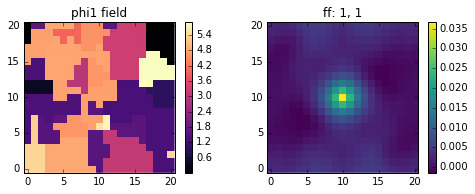

In [13]:
set_id = C['set_id_val'][3]  # index for the microstructure of interest
sn = 0  # index for the SVE of interest
iA = 6  # index for the correlation of interest
pltcorr.pltcorr(C, set_id=set_id , sn=sn, iA=iA)

### Get Reduced Dimensionality Representation
* Perform PCA to reduce dimensionality of spatial statistics representation
    * PCA finds an orthogonal linear combination of the original features such that the newly created features are ordered from highest to lowest variance. In our case this means that the spatial statistics may be represented with orders of magnitude fewer dimensions.
    
For an intuitive example of PCA (SVD) for image compression, check out this [link](http://www.frankcleary.com/svdimage/).

In [6]:
"""Perform PCA on correlations"""
pca = gns.new_space(C, C['ns_cal'], C['set_id_cal'])

print "Principal Component Analysis (PCA) performed"

"""transform statistics to reduced dimensionality space"""
f = h5py.File("spatial_reduced_L%s.hdf5" % C['H'], 'w')
f.close()

for ii in xrange(len(C['set_id_cal'])):
    tf.transform(C, C['ns_cal'][ii], C['set_id_cal'][ii], pca)

print "calibration SVEs transformed to PC representation"
    
for ii in xrange(len(C['set_id_val'])):
    tf.transform(C, C['ns_val'][ii], C['set_id_val'][ii], pca)
    
print "validation SVEs transformed to PC representation"

Principal Component Analysis (PCA) performed
calibration SVEs transformed to PC representation
validation SVEs transformed to PC representation


#### PCA Explained Variance Plot
* Plot variance in spatial statistics explained by increasing numbers of principal components (PCs) in PCA representation
* Nearly 100% of variance explained by first 5 PCs

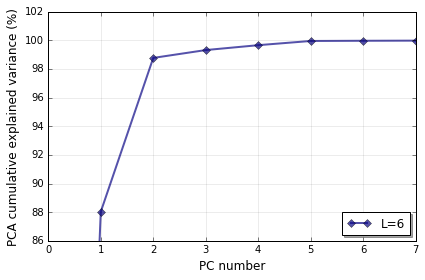

In [7]:
"""Plot the percentage explained variance"""
pev.variance(C, [0, 7, 86, 102], [C['H']])

#### Microstructure Clustering - SVE Map
* Plot SVEs associated with each microstructure for selected PCs
* Note that in the first two PCs the SVEs are well clustered by microstructure type.

Try changing **pcA** (valid values: 0-78) and **pcB** (valid values: 0-78) to look at the clustering in different dimensions.**

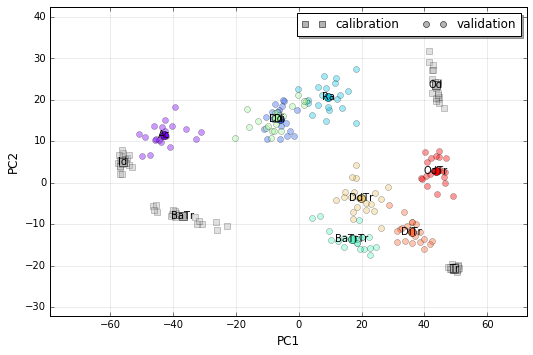

In [8]:
"""Plot the microstructures in PC space"""
pcA = 0
pcB = 1
pltmap.pltmap(C, C['H'], pcA, pcB)

# pcC = 2
# pltmap3d.pltmap(C, C['H'], pcA, pcB, pcC)

# """Plot a dendrogram"""
# pd.pltdend(C, C['ns_cal'] + C['ns_val'],
#            C['set_id_cal'] + C['set_id_val'],
#            C['names_cal'] + C['names_val'], C['H'])

### Generate Structure Property Linkages
* S-P linkages generated for elastic stiffness, yield strength
* created by fitting SVE PC representations to simulated properties with multivariate polynomial regression
* regressions performed considering different numbers of PCs

In [9]:
 """create the specified array of linkages and cross validate"""

f = h5py.File("regression_results_L%s.hdf5" % C['H'], 'w')
f.close()

gl.linkage(C, 'modulus')
print "linkage for elastic stiffness performed"

gl.linkage(C, 'strength')
print "linkage for yield strength performed"

linkage for elastic stiffness performed
linkage for yield strength performed


### Validate Structure-Property Linkages
#### Plot Prediction Error vs. Number of PCs
Three error measures plotted versus number of PCs included in multivariate regression for elastic stiffness and yield strength
* **Calibration error**
    * error in property prediction for calibration SVEs
    * calibration error decreases as number of PCs increases
* **LOOCV (Leave one out cross validation) error**
    * error in property prediction where one SVE is removed from calibration set and used to measure prediction error
    * Performed for all calibration SVEs
    * LOOCV error used to detect overfitting
    * LOOCV error first decreases, then increases as number of PCs increases
* **Validation error**
    * error in property prediction for validation SVEs
    * Validation error tends to decrease, then increase as number of PCs increases

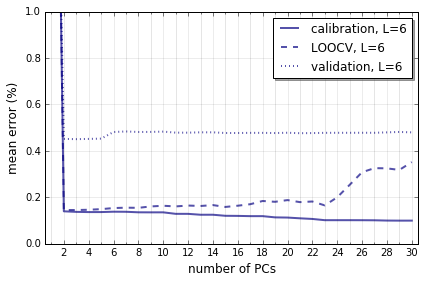

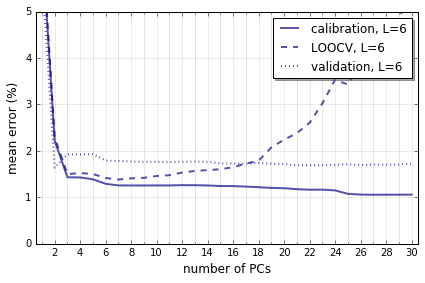

In [10]:
"""plot prediction error for elastic stiffness """
err_bnd = 1.0
pevp.plterr(C, 'modulus', 30, err_bnd, ['cal', 'LOOCV', 'val'], [C['H']])

"""plot prediction error for yield strength """
err_bnd = 5.0
pevp.plterr(C, 'strength', 30, err_bnd, ['cal', 'LOOCV', 'val'], [C['H']])


#### Plot Prediction Errors for Selected Linkage
* parity plot used to evaluate quality of S-P linkage for specified number of PCs
    * shows actual vs. predicted property
    * error bounds included for clarity and convenience

modulus
n_pc, n_poly: [[2 2]]
mean % error for cal: 0.139895032613
max % error for cal: 0.588213606113
mean % error for val: 0.451730304443
max % error for val: 1.62440350609
strength
n_pc, n_poly: [[2 2]]
mean % error for cal: 2.21419792711
max % error for cal: 7.23025903062
mean % error for val: 1.64018289141
max % error for val: 5.6972616917


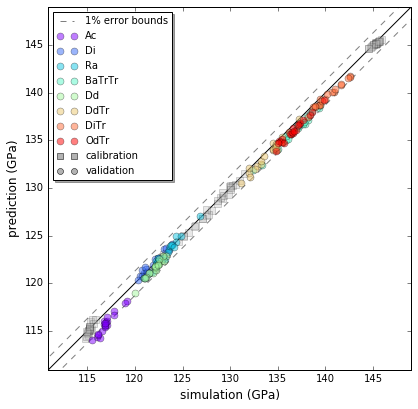

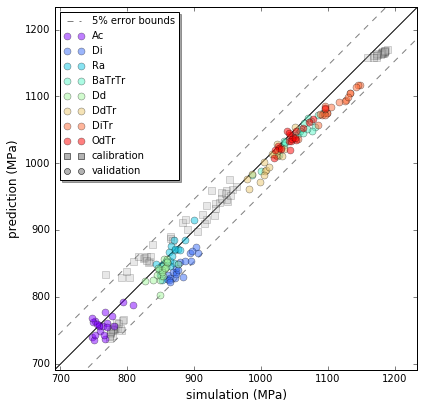

In [11]:
n_pc = 2  # select the number of PCs used in the S-P linkage

plc.plot_check(C, 'modulus', n_pc=n_pc, n_poly=2, H=C['H'], erv=1)
plc.plot_check(C, 'strength', n_pc=n_pc, n_poly=2, H=C['H'], erv=5)